In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pairwise_results = np.load('simulation_results/conditional_pairwise_results/all_results.npz')

In [3]:
pairwise_results.files

['divergences', 'pvals', 'sign_vectors']

In [4]:
pvals = pairwise_results['pvals']

In [5]:
pvals.shape

(91, 91, 500)

In [6]:
significant = pvals <= 0.01

In [7]:
pct_significant = np.nansum(significant, axis=2)/significant.shape[2]

In [8]:
pct_significant = np.triu(pct_significant, k=1)

In [9]:
from seaborn import heatmap

In [10]:
np.tril(np.ones((5,5)), k=0)

array([[1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.]])

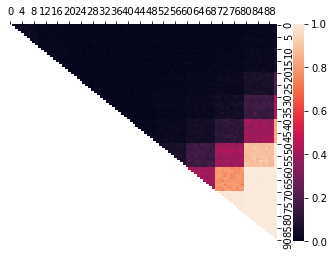

In [11]:
ax = heatmap(pct_significant, mask=np.tril(np.ones_like(pct_significant, dtype=bool), k=0))
ax.yaxis.tick_right()
ax.xaxis.tick_top()

ok wow oof there is a pretty darn pattern here in terms of increasing frequency

and at the same time it seems to possibly be relatively unimportant for lower frequencies? so maybe that's good?

but huh why would it be higher for higher frequencies? maybe there's more power to detect differences from the null? is that the only reason? hm maybe honestly idk... yeah that actually sounds fairly realistic tbh

In [12]:
sign_vectors = pairwise_results['sign_vectors']

In [13]:
sign_vectors.shape

(91, 91, 3, 500)

In [14]:
signs = sign_vectors[...,1,:]

In [15]:
signs.shape

(91, 91, 500)

this code isn't really correct since it looks at all signs, regardless of whether they're "significant"

In [16]:
pct_pos = np.nansum(signs > 0, axis=2)/signs.shape[2]

In [17]:
pct_neg = np.nansum(signs < 0, axis=2)/signs.shape[2]

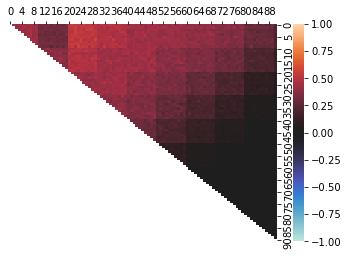

In [18]:
ax = heatmap(pct_pos, mask=np.tril(np.ones_like(pct_pos, dtype=bool), k=0), vmin=-1, vmax=1, cmap='icefire')
ax.yaxis.tick_right()
ax.xaxis.tick_top()

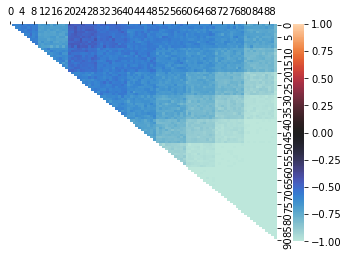

In [19]:
ax = heatmap(-pct_neg, mask=np.tril(np.ones_like(pct_pos, dtype=bool), k=0), vmin=-1, vmax=1, cmap='icefire')
ax.yaxis.tick_right()
ax.xaxis.tick_top()

oh wow shoot, over-dispersion is actually maybe a good thing?

looks like the lowest frequencies maybe get a boost (at least in relative proportion but crud I really should have computed/stored the total numbers but whatever), while the higher frequencies get a decrease, but who cares about them, since they are the ones that are easiest to estimate anyway? or something

so the fact that higher frequencies are statistically significantly different is probably a non-issue? well possibly. although it might mean we over-estimate out ability to estimate e.g. $1\%$ when in fact we actually need to go all the way up to $2\%$ or something like that. honestly I have no clue....

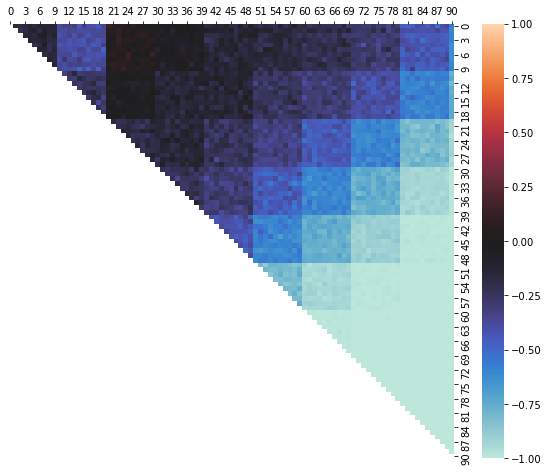

In [20]:
plt.figure(figsize=(10,8))

ax = heatmap(pct_pos-pct_neg, mask=np.tril(np.ones_like(pct_pos, dtype=bool), k=0), vmin=-1, vmax=1, cmap='icefire')
ax.yaxis.tick_right()
ax.xaxis.tick_top()

oof wow ok so the excess of positive over negative is never very substantial it seems? uh

yeah the lower frequencies seem to be like 50/50 pos. over neg, which does sort of correspond to what you'd expect more under the null than anything else right. so i guess this makes sense???

## skip non-significant things

In [21]:
significant.shape

(91, 91, 500)

In [22]:
signs.shape

(91, 91, 500)

In [23]:
signs[significant].shape

(2447129,)

In [24]:
signs[~significant] = 0

In [25]:
np.sum(np.isnan(signs))

0

In [26]:
pct_sig_pos = np.nansum(signs > 0, axis=2)/signs.shape[2]

In [27]:
pct_sig_neg = np.nansum(signs < 0, axis=2)/signs.shape[2]

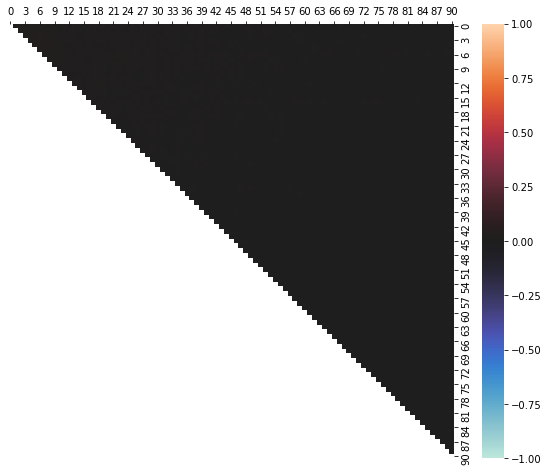

In [28]:
plt.figure(figsize=(10,8))
ax = heatmap(pct_sig_pos, mask=np.tril(np.ones_like(pct_pos, dtype=bool), k=0), vmin=-1, vmax=1, cmap='icefire')
ax.yaxis.tick_right()
ax.xaxis.tick_top()

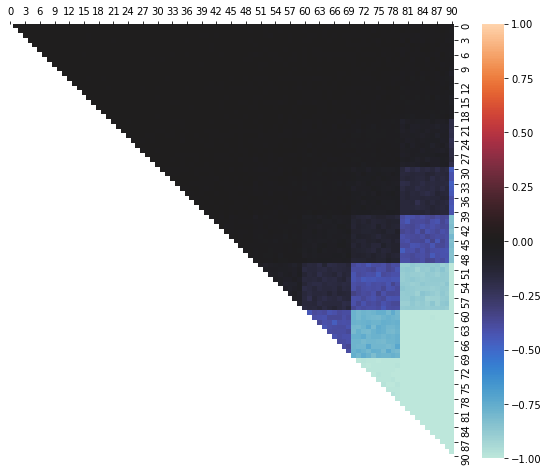

In [29]:
plt.figure(figsize=(10,8))
ax = heatmap(-pct_sig_neg, mask=np.tril(np.ones_like(pct_pos, dtype=bool), k=0), vmin=-1, vmax=1, cmap='icefire')
ax.yaxis.tick_right()
ax.xaxis.tick_top()

oh wow geez ok that's a pretty darn clear signal eesh

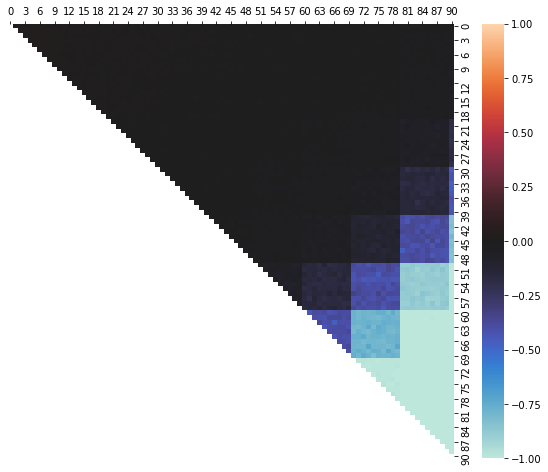

In [30]:
plt.figure(figsize=(10,8))
ax = heatmap(pct_sig_pos-pct_sig_neg, mask=np.tril(np.ones_like(pct_pos, dtype=bool), k=0), vmin=-1, vmax=1, cmap='icefire')
ax.yaxis.tick_right()
ax.xaxis.tick_top()

### let's do most conservative possible interpretation of multiple hypothesis correction

i.e. correct over/between all 500 simulations, not just within any specific simulation

In [31]:
from statsmodels.stats.multitest import multipletests

In [32]:
upper_triangular_indices = np.triu_indices_from(pct_sig_pos, k=1)

In [33]:
upper_triangular_indices

(array([ 0,  0,  0, ..., 88, 88, 89]), array([ 1,  2,  3, ..., 89, 90, 90]))

In [34]:
test = upper_triangular_indices[0][-10:]

In [35]:
test

array([86, 86, 86, 86, 87, 87, 87, 88, 88, 89])

In [36]:
np.repeat(test,2)

array([86, 86, 86, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87, 88, 88, 88,
       88, 89, 89])

In [37]:
len(np.repeat(test,2))

20

In [38]:
len(np.arange(0,20))

20

In [39]:
np.tile(np.arange(0,10),2)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [40]:
uber_indices = (np.repeat(upper_triangular_indices[0], 500), 
               np.repeat(upper_triangular_indices[1], 500),
               np.tile(np.arange(0,500), len(upper_triangular_indices[0])))

In [41]:
pvals = pairwise_results['pvals']

In [42]:
pvals.shape

(91, 91, 500)

In [43]:
upper_triangular_pvals = pvals[uber_indices[0], uber_indices[1], uber_indices[2]]

In [44]:
test = upper_triangular_pvals[0:len(upper_triangular_indices[0])]

In [45]:
test2 = pvals[...,0][upper_triangular_indices[0], upper_triangular_indices[1]]

In [46]:
test2

array([7.40750382e-01, 7.66052336e-01, 6.63359470e-01, ...,
       1.38619319e-38, 1.19465088e-72, 2.36785798e-72])

In [47]:
test

array([0.74075038, 0.6839973 , 0.24964466, ..., 0.82354904, 0.48343875,
       0.22686332])

of course they aren't equal, smh

well maybe it's correct but numpy just doesn't flatten the way you want it to flatten, you know?

blegh. first entries match at least

In [48]:
test3 = upper_triangular_pvals[::500]

In [49]:
len(test3)

4095

In [50]:
test3

array([7.40750382e-01, 7.66052336e-01, 6.63359470e-01, ...,
       1.38619319e-38, 1.19465088e-72, 2.36785798e-72])

In [51]:
np.all(test2 == upper_triangular_pvals[0::500])

True

In [52]:
for i in range(500):
    np.testing.assert_array_equal(pvals[...,i][upper_triangular_indices[0], upper_triangular_indices[1]],
                                  upper_triangular_pvals[i::500])

OK, I _guess_ that's a good sign? eh?

In [53]:
(unsorted_but_corrected_rejections,
unsorted_but_corrected_pvals) = multipletests(upper_triangular_pvals, alpha=0.001, method='holm', is_sorted=False)[0:2]

In [54]:
include = np.zeros(pvals.shape, dtype=bool)

In [55]:
include[uber_indices[0], uber_indices[1], uber_indices[2]] = unsorted_but_corrected_rejections

In [56]:
include.shape

(91, 91, 500)

In [57]:
corrected_pct_significant = np.nansum(include, axis=2)/include.shape[2]

In [58]:
corrected_pct_significant

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

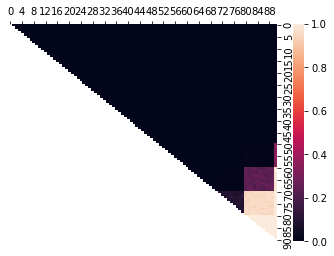

In [59]:
ax = heatmap(corrected_pct_significant, 
        mask=np.tril(np.ones_like(corrected_pct_significant, dtype=bool), k=0))
ax.yaxis.tick_right()
ax.xaxis.tick_top()

oof dang after multiple hypothesis testing the results actually do take a beating huh

guess I maybe can't afford to be as ridiculously conservative as I thought, idk

anyway not sure whether this was a context where one actually would want/need to "correct" for multiple hypothesis tests

anyway I guess we could also try once correcting for each simulation, but not across simulations...

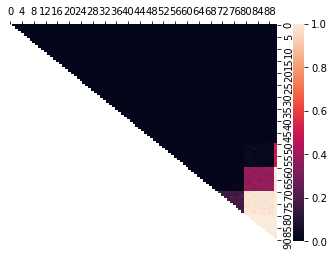

In [60]:
(unsorted_but_less_corrected_rejections,
unsorted_but_less_corrected_pvals) = multipletests(upper_triangular_pvals, alpha=0.01, method='holm', is_sorted=False)[0:2]

more_include = np.zeros(pvals.shape, dtype=bool)
more_include[uber_indices[0], uber_indices[1], uber_indices[2]] = unsorted_but_less_corrected_rejections

less_corrected_pct_significant = np.nansum(more_include, axis=2)/more_include.shape[2]
ax = heatmap(less_corrected_pct_significant, 
        mask=np.tril(np.ones_like(less_corrected_pct_significant, dtype=bool), k=0))
ax.yaxis.tick_right()
ax.xaxis.tick_top()

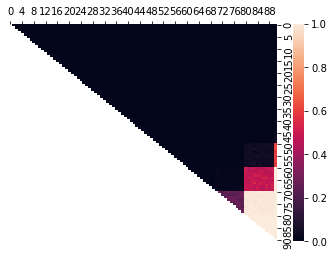

In [61]:
(unsorted_but_less_corrected_rejections,
unsorted_but_less_corrected_pvals) = multipletests(upper_triangular_pvals, alpha=0.05, method='holm', is_sorted=False)[0:2]

more_include = np.zeros(pvals.shape, dtype=bool)
more_include[uber_indices[0], uber_indices[1], uber_indices[2]] = unsorted_but_less_corrected_rejections

less_corrected_pct_significant = np.nansum(more_include, axis=2)/more_include.shape[2]
ax = heatmap(less_corrected_pct_significant, 
        mask=np.tril(np.ones_like(less_corrected_pct_significant, dtype=bool), k=0))
ax.yaxis.tick_right()
ax.xaxis.tick_top()

yeah there's just no getting around the fact that the corrections at this scale are honestly just brutal and overkill

## less conservative

In [62]:
most_include = np.zeros(pvals.shape, dtype=bool)

for i in range(500):
    temp_pvals = pvals[...,i][upper_triangular_indices[0], upper_triangular_indices[1]]
    
    (temp_unsorted_but_corrected_rejections,
    temp_unsorted_but_corrected_pvals) = multipletests(temp_pvals, alpha=0.001, method='holm', is_sorted=False)[0:2]
    
    most_include[...,i][upper_triangular_indices[0], upper_triangular_indices[1]] = temp_unsorted_but_corrected_rejections

hindsight is 20/20, but I should have just stored the non-nan corrected pvals in an array, and then gotten the rejections at different significance levels just using `<=`. Oh well. Guess that's what I'll do if I decide I need to re-run above at less stringent significance level.

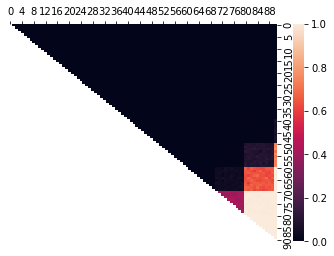

In [63]:
even_less_corrected_pct_significant = np.nansum(most_include, axis=2)/most_include.shape[2]
ax = heatmap(even_less_corrected_pct_significant, 
        mask=np.tril(np.ones_like(even_less_corrected_pct_significant, dtype=bool), k=0))
ax.yaxis.tick_right()
ax.xaxis.tick_top()

In [64]:
most_include_pvals = np.ones(pvals.shape)
# can't use zeros because those are highly significant actually so
debug = np.zeros(pvals.shape, dtype=bool)

for i in range(500):
    temp_pvals = pvals[...,i][upper_triangular_indices[0], upper_triangular_indices[1]]
    
    (temp_unsorted_but_corrected_rejections,
    temp_unsorted_but_corrected_pvals) = multipletests(temp_pvals, alpha=0.01, method='holm', is_sorted=False)[0:2]
    
    most_include_pvals[...,i][upper_triangular_indices[0], upper_triangular_indices[1]] = temp_unsorted_but_corrected_pvals
    debug[...,i][upper_triangular_indices[0], upper_triangular_indices[1]] = temp_unsorted_but_corrected_rejections

In [65]:
np.all( (most_include_pvals <= 0.01) == debug)

True

yay sanity

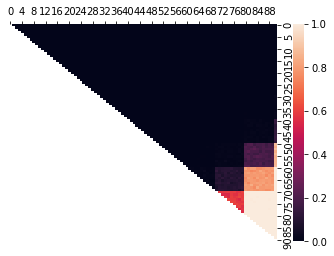

In [66]:
even_less_corrected_pct_significant = np.nansum(debug, axis=2)/debug.shape[2]
ax = heatmap(even_less_corrected_pct_significant, 
        mask=np.tril(np.ones_like(even_less_corrected_pct_significant, dtype=bool), k=0))
ax.yaxis.tick_right()
ax.xaxis.tick_top()

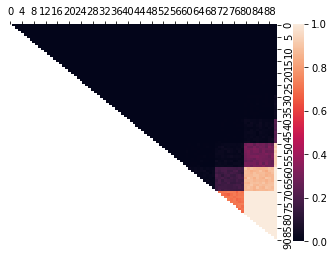

In [67]:
even_less_corrected_pct_significant = np.nansum((most_include_pvals <= 0.05), axis=2)/debug.shape[2]
ax = heatmap(even_less_corrected_pct_significant, 
        mask=np.tril(np.ones_like(even_less_corrected_pct_significant, dtype=bool), k=0))
ax.yaxis.tick_right()
ax.xaxis.tick_top()

let's try ridiculously high signifcance level:

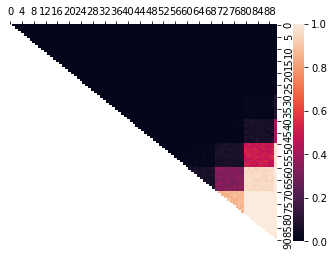

In [68]:
even_less_corrected_pct_significant = np.nansum((most_include_pvals <= 0.5), axis=2)/debug.shape[2]
ax = heatmap(even_less_corrected_pct_significant, 
        mask=np.tril(np.ones_like(even_less_corrected_pct_significant, dtype=bool), k=0))
ax.yaxis.tick_right()
ax.xaxis.tick_top()

What? like were they really not different from null, or are the lower frequency interactions just under-powered? I'm guessing the latter, given how systematic the trend was (like seriously)

also I really don't think the multiple correction makes sense here. but anyway we can include the multiple corrected figures in an appendix at least just to argue that the qualitiative conclusions don't really depend on this so yeah